In [24]:
from google.colab import drive
drive.mount('/content/drive')

import os
base_dir = "/content/drive/MyDrive/data_all"

#6 lang
langs = ["gr", "hi", "ar", "ko", "irish", "baoule"]
langs_label = {"gr":0, "hi":1, "ar":2, "ko":3, "irish":4, "baoule":5}
target_names = ["German", "Hindi", "Arabic", "Korean", "Irish", "Baoule"]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# random split

import random, shutil

random.seed(42)

def split_and_copy(lang, base_dir, max_files=5000, train_ratio=0.75, val_ratio=0.125, test_ratio=0.125):
    clips_dir = os.path.join(base_dir, lang, "clips")
    files = [f for f in os.listdir(clips_dir) if f.lower().endswith(".mp3")]


    if len(files) > max_files:
        files = random.sample(files, max_files)
    else:
        random.shuffle(files)

    n = len(files)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)

    splits = {
        "train": files[:n_train],
        "val": files[n_train:n_train+n_val],
        "test": files[n_train+n_val:]
    }

    for split, split_files in splits.items():
        split_dir = os.path.join(base_dir, lang, split)
        os.makedirs(split_dir, exist_ok=True)

        for f in split_files:
            src = os.path.join(clips_dir, f)
            dst = os.path.join(split_dir, f)
            if not os.path.exists(dst):
                shutil.copy2(src, dst)

    print(f"{lang.upper()} -> {len(files)} used | "
          f"train: {len(splits['train'])}, val: {len(splits['val'])}, test: {len(splits['test'])}")

for lang in langs:
    split_and_copy(lang, base_dir)


GR -> 5000 used | train: 3750, val: 625, test: 625
HI -> 5000 used | train: 3750, val: 625, test: 625
AR -> 5000 used | train: 3750, val: 625, test: 625
KO -> 5000 used | train: 3750, val: 625, test: 625
IRISH -> 5000 used | train: 3750, val: 625, test: 625
BAOULE -> 5000 used | train: 3750, val: 625, test: 625


In [27]:
#feature extraction(mel spectrogram)

import librosa
import numpy as np

n_mels = 80      #number of mel frequency bins
max_len = 128    #number of time steps
sr = 16000       #target sample rate

def audio_to_melspec(path):
    #load and resample audio
    y, sr_loaded = librosa.load(path, sr=sr)

    y = librosa.effects.preemphasis(y)

    #trim silence
    y, _ = librosa.effects.trim(y, top_db=20)

    # create melspectrogram
    s = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=8000)

    log_s = librosa.power_to_db(s, ref=np.max)

    #ensure fixed width
    if log_s.shape[1] < max_len:
        pad_width = max_len - log_s.shape[1]
        log_s = np.pad(log_s, ((0,0),(0,pad_width)), mode="constant")
    else:
        log_s = log_s[:, :max_len]

    return log_s.astype(np.float32)


In [28]:
#data augmentation

import random

def augment_audio(y, sr):
    augmented = []

    #add small gaussian noise
    noise = np.random.normal(0, 0.005, y.shape)
    augmented.append(y + noise)

    rate = random.uniform(0.85, 1.15)
    stretched = librosa.effects.time_stretch(y, rate=rate)
    #match original length
    if len(stretched) < len(y):
        stretched = np.pad(stretched, (0, len(y) - len(stretched)))
    else:
        stretched = stretched[:len(y)]
    augmented.append(stretched)

    #pitch shift
    n_steps = random.choice([-2, -1, 1, 2])
    pitched = librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)
    augmented.append(pitched)

    return augmented


In [30]:
#load train val and test
import os

def load_split(split, augment=False):
    x, y = [], []
    for lang, label in langs_label.items():
        folder = os.path.join(base_dir, lang, split)
        files = [f for f in os.listdir(folder) if f.lower().endswith(".mp3")]
        print(f"{lang.upper()} -> loading {len(files)} files from {split}...")

        for f in files:
            path = os.path.join(folder, f)
            try:
                wav, _ = librosa.load(path, sr=sr)
                spec = audio_to_melspec(path)
                x.append(spec)
                y.append(label)

                if split == "train" and augment:
                    for aug_audio in augment_audio(wav, sr):
                        spec_aug = librosa.feature.melspectrogram(
                            y=aug_audio, sr=sr, n_mels=n_mels, fmax=8000
                        )
                        log_s = librosa.power_to_db(spec_aug, ref=np.max)
                        if log_s.shape[1] < max_len:
                            pad = max_len - log_s.shape[1]
                            log_s = np.pad(log_s, ((0,0),(0,pad)), mode="constant")
                        else:
                            log_s = log_s[:, :max_len]
                        x.append(log_s.astype(np.float32))
                        y.append(label)
            except Exception as e:
                print(f"skipped {path}: {e}")
    return np.array(x, dtype=np.float32), np.array(y, dtype=np.int64)

x_train, y_train = load_split("train", augment=True)
x_val,   y_val   = load_split("val")
x_test,  y_test  = load_split("test")

print("loaded data")
print("train:", x_train.shape, y_train.shape)
print("val:",   x_val.shape,   y_val.shape)
print("test:",  x_test.shape,  y_test.shape)


GR -> loading 3750 files from train...
HI -> loading 3914 files from train...
AR -> loading 3750 files from train...
KO -> loading 3750 files from train...
IRISH -> loading 3750 files from train...
BAOULE -> loading 3750 files from train...
GR -> loading 625 files from val...
HI -> loading 625 files from val...
AR -> loading 625 files from val...
KO -> loading 625 files from val...
IRISH -> loading 625 files from val...
BAOULE -> loading 625 files from val...
GR -> loading 625 files from test...
HI -> loading 625 files from test...
AR -> loading 625 files from test...
KO -> loading 625 files from test...
IRISH -> loading 625 files from test...
BAOULE -> loading 625 files from test...
loaded data
train: (90656, 80, 128) (90656,)
val: (3750, 80, 128) (3750,)
test: (3750, 80, 128) (3750,)


In [31]:
import numpy as np

save_dir = "/content/drive/MyDrive/data_all/preprocessed_6lang"
os.makedirs(save_dir, exist_ok=True)

np.save(os.path.join(save_dir, "x_train.npy"), x_train)
np.save(os.path.join(save_dir, "y_train.npy"), y_train)
np.save(os.path.join(save_dir, "x_val.npy"), x_val)
np.save(os.path.join(save_dir, "y_val.npy"), y_val)
np.save(os.path.join(save_dir, "x_test.npy"), x_test)
np.save(os.path.join(save_dir, "y_test.npy"), y_test)

print("Saved all preprocessed arrays to:", save_dir)


Saved all preprocessed arrays to: /content/drive/MyDrive/data_all/preprocessed_6lang


In [32]:
#normalization

mu = x_train.mean()
sigma = x_train.std() + 1e-6

x_train_n = ((x_train - mu) / sigma)[..., np.newaxis]
x_val_n   = ((x_val   - mu) / sigma)[..., np.newaxis]
x_test_n  = ((x_test  - mu) / sigma)[..., np.newaxis]

print("normalized shapes:")
print("train:", x_train_n.shape, y_train.shape)
print("val:",   x_val_n.shape,   y_val.shape)
print("test:",  x_test_n.shape,  y_test.shape)


normalized shapes:
train: (90656, 80, 128, 1) (90656,)
val: (3750, 80, 128, 1) (3750,)
test: (3750, 80, 128, 1) (3750,)


In [36]:
#model building
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def make_model():
    inp = layers.Input(shape=(80, 128, 1))
    x = layers.Conv2D(32, (5,5), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(1e-4))(inp)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(64, (3,3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (3,3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Conv2D(256, (3,3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(128, activation='relu',
                     kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.4)(x)

    out = layers.Dense(6, activation='softmax')(x)
    model = models.Model(inp, out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

model = make_model()
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 80, 128, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 80, 128, 32)    │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 80, 128, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 40, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 40, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 40, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 40, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 20, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 20, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 20, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 20, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 10, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 10, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 10, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 10, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,942 (1.62 MB)

 Trainable params: 422,982 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [37]:
#training

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

#define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_6lang_lid.keras', monitor='val_loss', save_best_only=True)
]

weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))
print("class weights:", class_weights)

# train model
history = model.fit(
    x_train_n, y_train,
    validation_data=(x_val_n, y_val),
    epochs=20,
    batch_size=64,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1,
    shuffle=True
)


class weights: {0: np.float64(1.007288888888889), 1: np.float64(0.9650826094362119), 2: np.float64(1.007288888888889), 3: np.float64(1.007288888888889), 4: np.float64(1.007288888888889), 5: np.float64(1.007288888888889)}
Epoch 1/20
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 29s 14ms/step - accuracy: 0.4256 - loss: 1.4981 - val_accuracy: 0.3992 - val_loss: 3.2223 - learning_rate: 2.0000e-04
Epoch 2/20
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6354 - loss: 1.0381 - val_accuracy: 0.5907 - val_loss: 1.4621 - learning_rate: 2.0000e-04
Epoch 3/20
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7093 - loss: 0.8620 - val_accuracy: 0.6024 - val_loss: 1.3415 - learning_rate: 2.0000e-04
Epoch 4/20
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7423 - loss: 0.7702 - val_accuracy: 0.7000 - val_loss: 0.9456 - learning_rate: 2.0000e-04
Epoch 5/20
1417/1417 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7692 - loss: 0.7033 - val_accuracy: 0.7299 - val_loss: 0.8104 - learning_

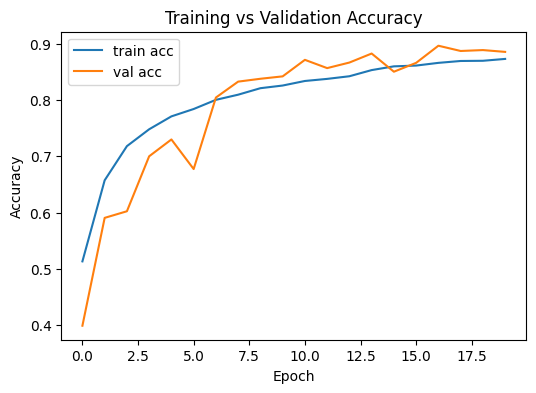

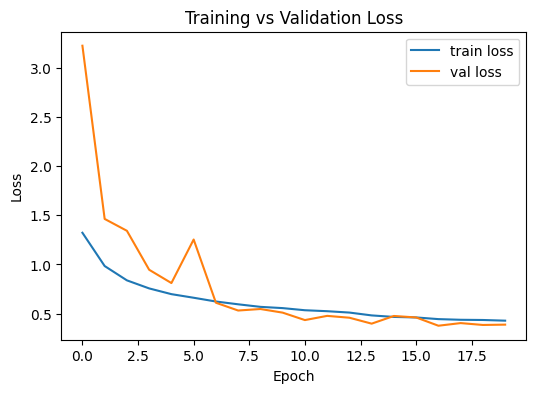

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()



Test Accuracy: 0.9008 | Test Loss: 0.3488

Classification Report:
              precision    recall  f1-score   support

      German     0.8630    0.9376    0.8988       625
       Hindi     0.9277    0.8416    0.8826       625
      Arabic     0.8289    0.9456    0.8834       625
      Korean     0.9051    0.9008    0.9030       625
       Irish     0.9418    0.8032    0.8670       625
      Baoule     0.9591    0.9760    0.9675       625

    accuracy                         0.9008      3750
   macro avg     0.9043    0.9008    0.9004      3750
weighted avg     0.9043    0.9008    0.9004      3750



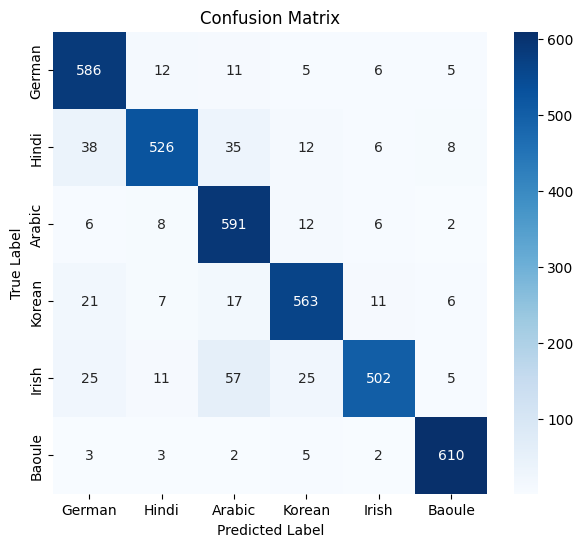

In [39]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#evaluation on test data
test_loss, test_acc = model.evaluate(x_test_n, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

# predictions
y_pred = np.argmax(model.predict(x_test_n, verbose=0), axis=1)

# classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names, digits=4))

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
